In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics # For F1 score

# Fuzzy System for Fat Intake Prediction
# 0. Pre-processing

In [2]:
fat_df = pd.read_csv('./fuzzy_macros_dataset_bmi.csv')
fat_df.head()

,BMI,BodyFat,Sex,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
0,21.45,13.6,F,19,135.1,1801,60.0,180.1
1,23.53,8.8,M,57,161.2,2150,71.7,215.0
2,22.15,23.1,F,20,144.2,1923,64.1,192.3
3,23.61,11.9,M,32,189.7,2529,84.3,252.9
4,21.47,17.6,F,18,144.4,1925,64.2,192.5


In [3]:
fat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   BMI              95 non-null     float64
 1   BodyFat          95 non-null     float64
 2   Sex              95 non-null     object 
 3   Age              95 non-null     int64  
 4   Protein_g        95 non-null     float64
 5   Calories_kcal    95 non-null     int64  
 6   Fat_g            95 non-null     float64
 7   Carbohydrates_g  95 non-null     float64
dtypes: float64(5), int64(2), object(1)
memory usage: 6.1+ KB


In [4]:
fat_df.describe()

,BMI,BodyFat,Age,Protein_g,Calories_kcal,Fat_g,Carbohydrates_g
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,23.721579,18.813684,35.905263,162.116842,2161.578947,72.049474,216.157895
std,3.279800,7.392386,16.680396,22.646899,301.962291,10.063637,30.196229
min,17.640000,3.000000,18.000000,124.100000,1655.000000,55.200000,165.500000
25%,21.370000,13.750000,21.000000,144.500000,1926.500000,64.250000,192.650000
50%,23.400000,18.600000,32.000000,161.600000,2155.000000,71.800000,215.500000
75%,26.050000,23.950000,48.500000,177.800000,2370.500000,79.000000,237.050000
max,31.860000,34.700000,72.000000,212.000000,2827.000000,94.200000,282.700000


### Outlier Detection and Removal

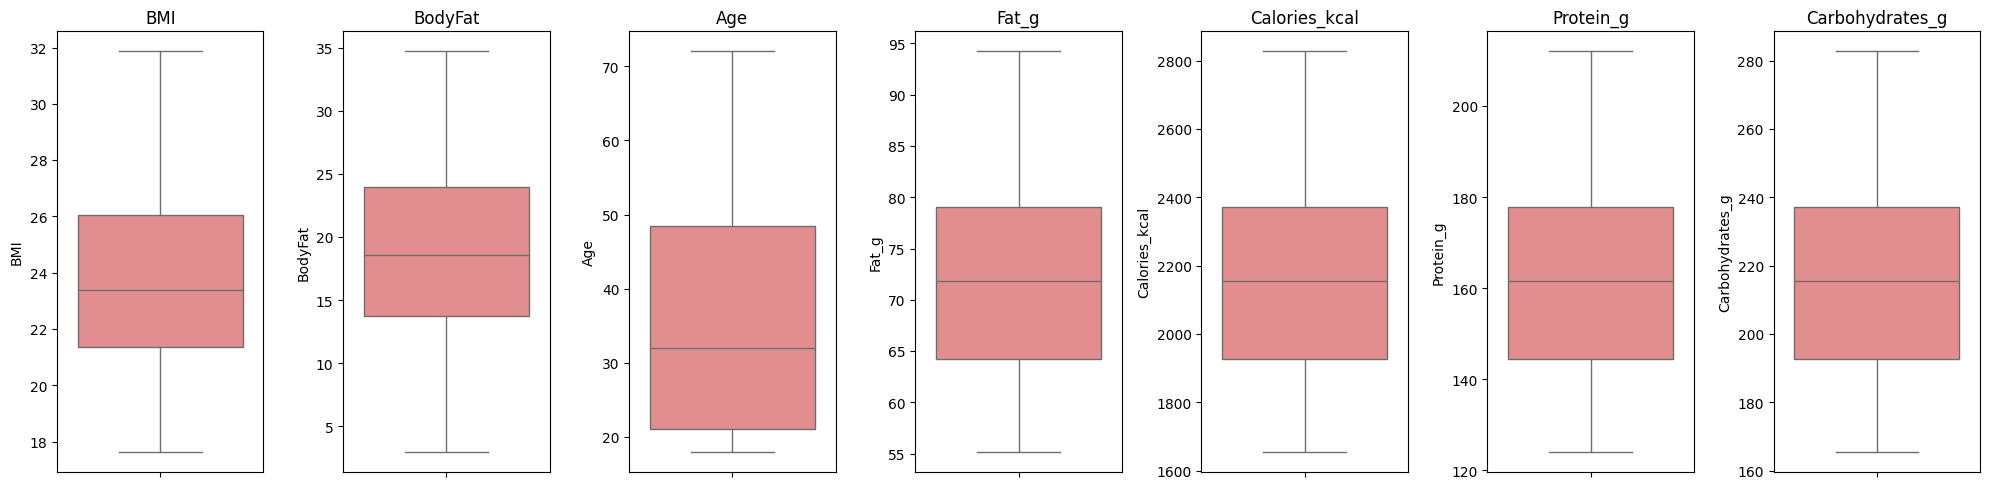

In [5]:
# Visualisasi persebaran data menggunakan boxplot untuk mengidentifikasi outlier
numeric_columns_check = ['BMI', 'BodyFat', 'Age', 'Fat_g', 'Calories_kcal', 'Protein_g', 'Carbohydrates_g'] # Added Fat_g
n_check = len(numeric_columns_check)

plt.figure(figsize=(20, 5))

for i, column in enumerate(numeric_columns_check): 
    plt.subplot(1, n_check, i+1)
    sns.boxplot(y=fat_df[column], color='lightcoral')
    plt.title(column)

plt.tight_layout()
plt.show()

Data count before IQR outlier removal: 95
BMI: Dihapus 0 data outlier
BodyFat: Dihapus 0 data outlier
Age: Dihapus 0 data outlier
Fat_g: Dihapus 0 data outlier
Data count after IQR outlier removal: 95


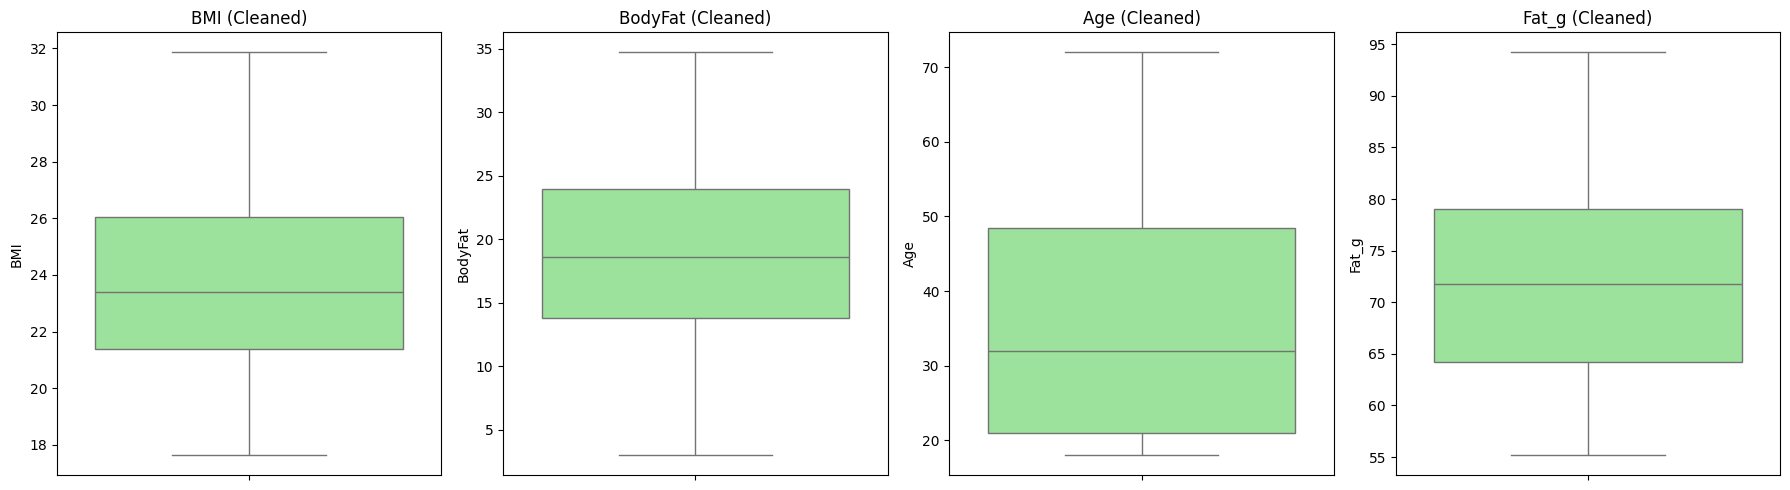

In [6]:
# Kolom yang relevan untuk fuzzy system (inputs + target)
relevant_columns_for_fuzzy_fat = ['BMI', 'BodyFat', 'Age', 'Fat_g'] 

# Filter dan menghapus data dari outlier dengan metode IQR (Interquartile Range)
df_cleaned = fat_df.copy()
print(f"Data count before IQR outlier removal: {df_cleaned.shape[0]}")
for column in relevant_columns_for_fuzzy_fat:
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    before_col = df_cleaned.shape[0]
    df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    after_col = df_cleaned.shape[0]
    print(f"{column}: Dihapus {before_col - after_col} data outlier")
print(f"Data count after IQR outlier removal: {df_cleaned.shape[0]}")

# Visualisasi persebaran data setelah menghapus outlier
plt.figure(figsize=(18, 5))
for i, column in enumerate(relevant_columns_for_fuzzy_fat): 
    plt.subplot(1, len(relevant_columns_for_fuzzy_fat), i+1)
    sns.boxplot(y=df_cleaned[column], color='lightgreen')
    plt.title(f'{column} (Cleaned)')

plt.tight_layout()
plt.show()

### Physiological Data Filtering
Berdasarkan `Fuzzy System Definition_Fat Intake.md`:
- Age universe: [18, 80]
- BMI universe: [15, 50]
- BodyFat Men universe: [2, 60]
- BodyFat Women universe: [10, 60]
- Fat_g universe: [40, 120]

Filter data untuk tetap berada dalam rentang yang masuk akal untuk MFs ini.

In [7]:
print(f"Data count before physiological filtering: {df_cleaned.shape[0]}")

# Age filter
df_cleaned = df_cleaned[(df_cleaned['Age'] >= 18) & (df_cleaned['Age'] <= 80)]

# BMI filter
df_cleaned = df_cleaned[(df_cleaned['BMI'] >= 15) & (df_cleaned['BMI'] <= 50)]

# BodyFat filter (gender-specific)
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'M') & ((df_cleaned['BodyFat'] < 2) | (df_cleaned['BodyFat'] > 60)))]
df_cleaned = df_cleaned[~((df_cleaned['Sex'] == 'F') & ((df_cleaned['BodyFat'] < 10) | (df_cleaned['BodyFat'] > 60)))]

# Fat_g filter (target variable, for reasonable evaluation range)
# Using a slightly wider range than MFs to capture actual data distribution, MFs will handle values outside their strict core ranges.
df_cleaned = df_cleaned[(df_cleaned['Fat_g'] >= 30) & (df_cleaned['Fat_g'] <= 150)] 

print(f"Data count after physiological filtering: {df_cleaned.shape[0]}")

Data count before physiological filtering: 95
Data count after physiological filtering: 94


# 1. Linguistic variables and Membership Functions (MFs)

### Helper functions for MFs

In [8]:
def trapmf(x, abcd):
    a, b, c, d = abcd
    if a > b: raise ValueError('a > b')
    if b > c: raise ValueError('b > c') # Allow b == c for triangular
    if c > d: raise ValueError('c > d')
        
    y = np.zeros_like(x if isinstance(x, np.ndarray) else [x])
    
    # Handle scalar input
    if not isinstance(x, np.ndarray):
        x = np.array([x])
        y = np.zeros_like(x, dtype=float)
        single_value = True
    else:
        y = np.zeros_like(x, dtype=float)
        single_value = False

    # Left slope
    if a != b:
        idx = np.logical_and(x >= a, x < b)
        y[idx] = (x[idx] - a) / (b - a)

    # Top part
    idx = np.logical_and(x >= b, x <= c)
    y[idx] = 1

    # Right slope
    if c != d:
        idx = np.logical_and(x > c, x <= d)
        y[idx] = (d - x[idx]) / (d - c)

    return y[0] if single_value else y
        
    return y[0] if isinstance(y, np.ndarray) and y.size == 1 else y

def trimf(x, abc):
    a, b, c = abc
    if a > b: raise ValueError('a > b in trimf')
    if b > c: raise ValueError('b > c in trimf')
    return trapmf(x, [a, b, b, c])

### Input: BMI (kg/m²)

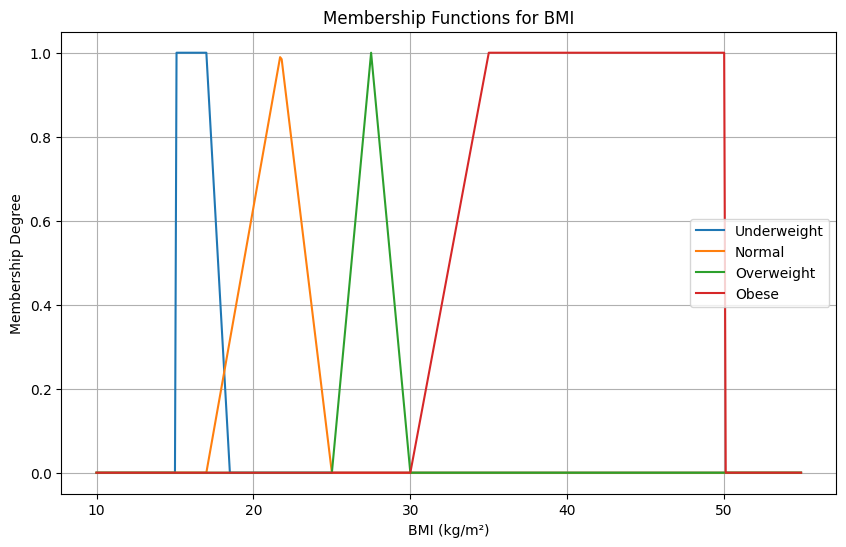

In [9]:
def bmi_underweight(bmi):
    return trapmf(bmi, [15, 15, 17, 18.5])

def bmi_normal(bmi):
    return trimf(bmi, [17, 21.75, 25])

def bmi_overweight(bmi):
    return trimf(bmi, [25, 27.5, 30])

def bmi_obese(bmi):
    return trapmf(bmi, [30, 35, 50, 50])

# Visualize BMI MFs
x_bmi_vis = np.arange(10, 55, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bmi_vis, bmi_underweight(x_bmi_vis), label='Underweight')
plt.plot(x_bmi_vis, bmi_normal(x_bmi_vis), label='Normal')
plt.plot(x_bmi_vis, bmi_overweight(x_bmi_vis), label='Overweight')
plt.plot(x_bmi_vis, bmi_obese(x_bmi_vis), label='Obese')
plt.title('Membership Functions for BMI')
plt.xlabel('BMI (kg/m²)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: BodyFat % (Men)

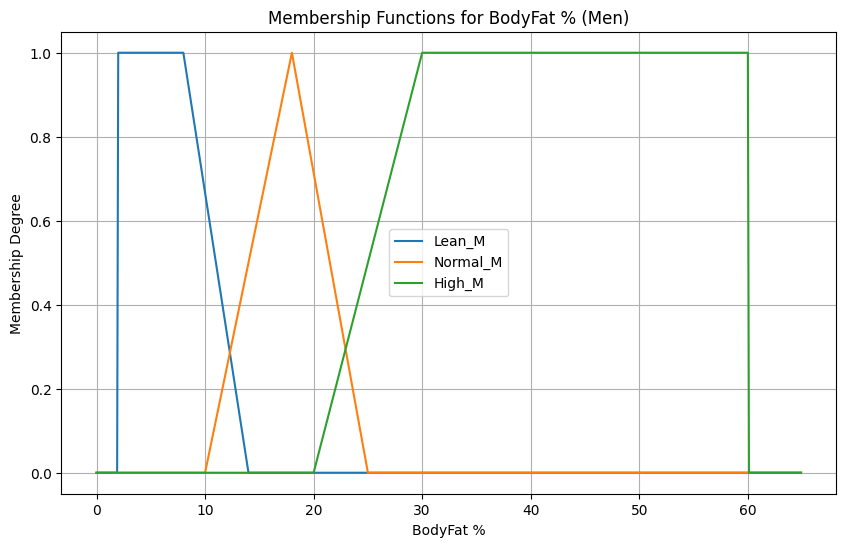

In [10]:
def bfm_lean(bodyfat):
    return trapmf(bodyfat, [2, 2, 8, 14])

def bfm_normal(bodyfat):
    return trimf(bodyfat, [10, 18, 25])

def bfm_high(bodyfat):
    return trapmf(bodyfat, [20, 30, 60, 60])

# Visualize BodyFat Men MFs
x_bf_m_vis = np.arange(0, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_m_vis, bfm_lean(x_bf_m_vis), label='Lean_M')
plt.plot(x_bf_m_vis, bfm_normal(x_bf_m_vis), label='Normal_M')
plt.plot(x_bf_m_vis, bfm_high(x_bf_m_vis), label='High_M')
plt.title('Membership Functions for BodyFat % (Men)')
plt.xlabel('BodyFat %')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: BodyFat % (Women)

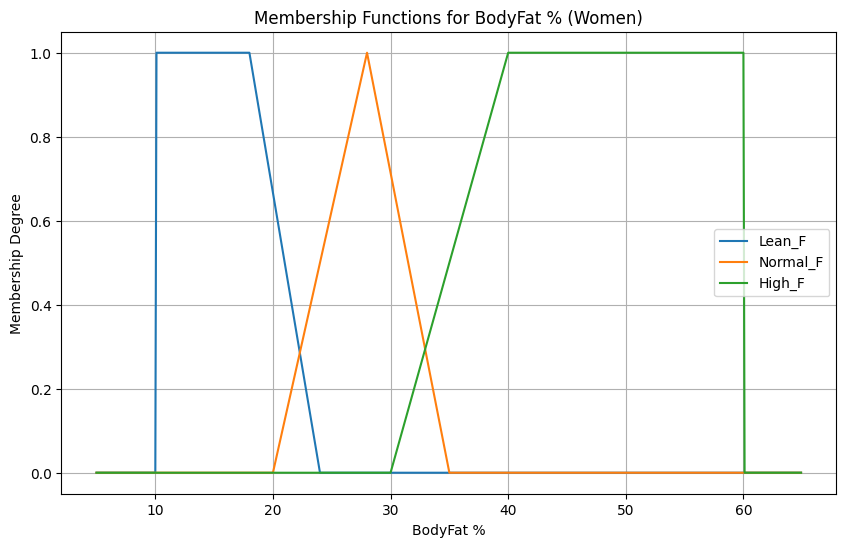

In [11]:
def bfw_lean(bodyfat):
    return trapmf(bodyfat, [10, 10, 18, 24])

def bfw_normal(bodyfat):
    return trimf(bodyfat, [20, 28, 35])

def bfw_high(bodyfat):
    return trapmf(bodyfat, [30, 40, 60, 60])

# Visualize BodyFat Women MFs
x_bf_f_vis = np.arange(5, 65, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_bf_f_vis, bfw_lean(x_bf_f_vis), label='Lean_F')
plt.plot(x_bf_f_vis, bfw_normal(x_bf_f_vis), label='Normal_F')
plt.plot(x_bf_f_vis, bfw_high(x_bf_f_vis), label='High_F')
plt.title('Membership Functions for BodyFat % (Women)')
plt.xlabel('BodyFat %')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Input: Age (years)

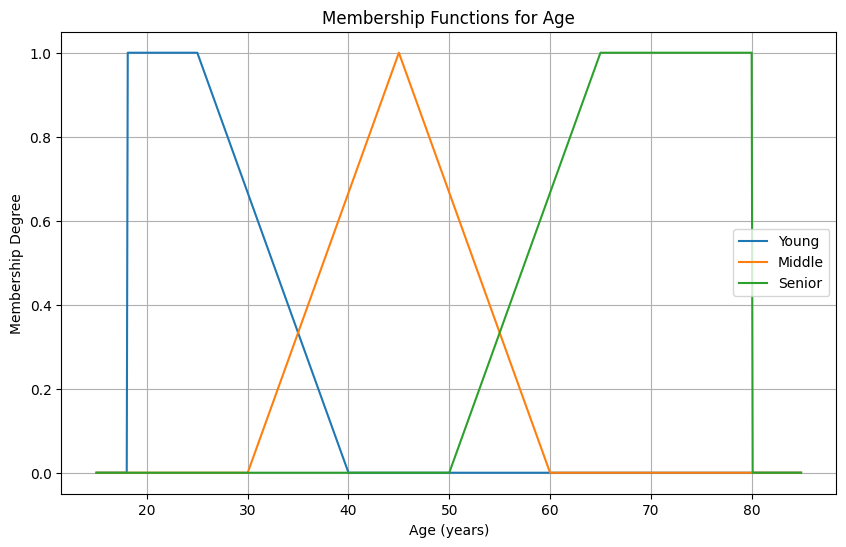

In [12]:
def age_young(age):
    return trapmf(age, [18, 18, 25, 40])

def age_middle(age):
    return trimf(age, [30, 45, 60])

def age_senior(age):
    return trapmf(age, [50, 65, 80, 80])

# Visualize Age MFs
x_age_vis = np.arange(15, 85, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_age_vis, age_young(x_age_vis), label='Young')
plt.plot(x_age_vis, age_middle(x_age_vis), label='Middle')
plt.plot(x_age_vis, age_senior(x_age_vis), label='Senior')
plt.title('Membership Functions for Age')
plt.xlabel('Age (years)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

### Output: Fat Intake (g)

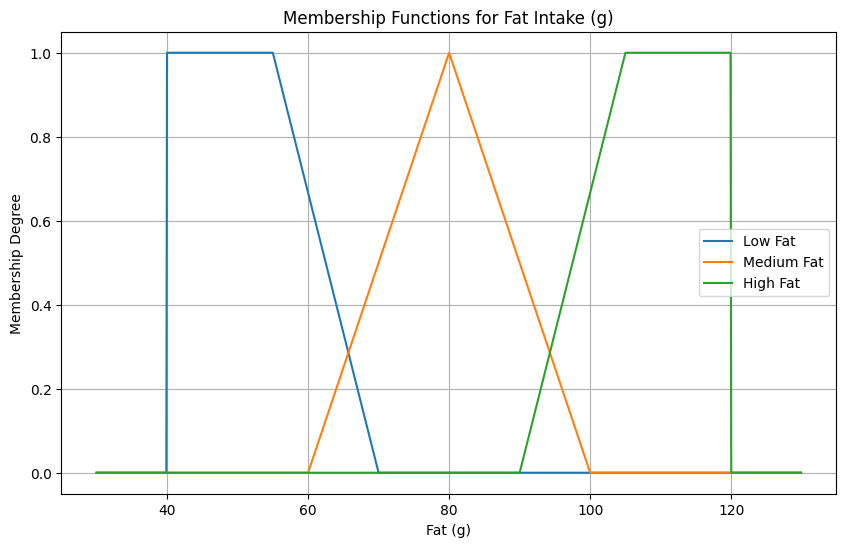

In [13]:
# Mamdani MFs for Fat
def fat_low_mf(fat):
    return trapmf(fat, [40, 40, 55, 70])

def fat_medium_mf(fat):
    return trimf(fat, [60, 80, 100])

def fat_high_mf(fat):
    return trapmf(fat, [90, 105, 120, 120])

# Sugeno Constants for Fat
fat_sugeno_constants = {
    'Low': 55,
    'Medium': 80,
    'High': 105
}

# Visualize Fat MFs (Mamdani)
x_fat_vis = np.arange(30, 130, 0.1)
plt.figure(figsize=(10, 6))
plt.plot(x_fat_vis, fat_low_mf(x_fat_vis), label='Low Fat')
plt.plot(x_fat_vis, fat_medium_mf(x_fat_vis), label='Medium Fat')
plt.plot(x_fat_vis, fat_high_mf(x_fat_vis), label='High Fat')
plt.title('Membership Functions for Fat Intake (g)')
plt.xlabel('Fat (g)')
plt.ylabel('Membership Degree')
plt.legend()
plt.grid(True)
plt.show()

# 2. Fuzzification

In [14]:
bmi_mf_terms = {
    'Underweight': bmi_underweight,
    'Normal': bmi_normal,
    'Overweight': bmi_overweight,
    'Obese': bmi_obese
}

bodyfat_m_mf_terms = { # Men
    'Lean_M': bfm_lean, 
    'Normal_M': bfm_normal, 
    'High_M': bfm_high
}

bodyfat_f_mf_terms = { # Women
    'Lean_F': bfw_lean, 
    'Normal_F': bfw_normal, 
    'High_F': bfw_high
}

age_mf_terms = {
    'Young': age_young,
    'Middle': age_middle,
    'Senior': age_senior
}

fat_output_mamdani_terms = {
    'Low': fat_low_mf,
    'Medium': fat_medium_mf,
    'High': fat_high_mf
}

In [15]:
def fuzzify_inputs(bmi, bodyfat, sex, age):
    fuzz_bmi = {term: mf(bmi) for term, mf in bmi_mf_terms.items()}
    
    if sex == 'M':
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_m_mf_terms.items()}
    else: # sex == 'F'
        fuzz_bf = {term: mf(bodyfat) for term, mf in bodyfat_f_mf_terms.items()}
        
    fuzz_age = {term: mf(age) for term, mf in age_mf_terms.items()}
    
    return fuzz_bmi, fuzz_bf, fuzz_age

# Example fuzzification for Fat system
example_bmi_fat = 27
example_bf_fat = 26
example_sex_fat = 'F'
example_age_fat = 45

f_bmi_fat, f_bf_fat, f_age_fat = fuzzify_inputs(example_bmi_fat, example_bf_fat, example_sex_fat, example_age_fat)
print(f"Fuzzified BMI for {example_bmi_fat}: {f_bmi_fat}")
print(f"Fuzzified BodyFat ({example_sex_fat}) for {example_bf_fat}%: {f_bf_fat}")
print(f"Fuzzified Age for {example_age_fat} years: {f_age_fat}")

Fuzzified BMI for 27: {'Underweight': np.float64(0.0), 'Normal': np.float64(0.0), 'Overweight': np.float64(0.8), 'Obese': np.float64(0.0)}
Fuzzified BodyFat (F) for 26%: {'Lean_F': np.float64(0.0), 'Normal_F': np.float64(0.75), 'High_F': np.float64(0.0)}
Fuzzified Age for 45 years: {'Young': np.float64(0.0), 'Middle': np.float64(1.0), 'Senior': np.float64(0.0)}


# 3. Inference Engine (Rule Evaluation)

In [16]:
# Rules for Fat Intake
# (Sex, BMI_Term, BodyFat_Term, Age_Term, Fat_Output_Term)
fat_rules = [
    # Men
    ('M', 'Underweight', 'Lean_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Underweight', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Young', 'Medium'),
    ('M', 'Underweight', 'Normal_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Underweight', 'High_M', 'Young', 'Low'),
    ('M', 'Underweight', 'High_M', 'Middle', 'Low'),
    ('M', 'Underweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Normal', 'Lean_M', 'Young', 'High'),
    ('M', 'Normal', 'Lean_M', 'Middle', 'High'),
    ('M', 'Normal', 'Lean_M', 'Senior', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Young', 'High'),
    ('M', 'Normal', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Normal', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Normal', 'High_M', 'Young', 'Medium'),
    ('M', 'Normal', 'High_M', 'Middle', 'Low'),
    ('M', 'Normal', 'High_M', 'Senior', 'Low'),
    ('M', 'Overweight', 'Lean_M', 'Young', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Lean_M', 'Senior', 'Medium'),
    ('M', 'Overweight', 'Normal_M', 'Young', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Middle', 'High'),
    ('M', 'Overweight', 'Normal_M', 'Senior', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Young', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Middle', 'Medium'),
    ('M', 'Overweight', 'High_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Lean_M', 'Young', 'High'),
    ('M', 'Obese', 'Lean_M', 'Middle', 'Medium'),
    ('M', 'Obese', 'Lean_M', 'Senior', 'Low'),
    ('M', 'Obese', 'Normal_M', 'Young', 'High'),
    ('M', 'Obese', 'Normal_M', 'Middle', 'Medium'),
    ('M', 'Obese', 'Normal_M', 'Senior', 'Low'),
    ('M', 'Obese', 'High_M', 'Young', 'Medium'),
    ('M', 'Obese', 'High_M', 'Middle', 'Low'),
    ('M', 'Obese', 'High_M', 'Senior', 'Low'),
    # Women
    ('F', 'Underweight', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Underweight', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Young', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Underweight', 'High_F', 'Young', 'Low'),
    ('F', 'Underweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Underweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Lean_F', 'Young', 'High'),
    ('F', 'Normal', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Normal', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Normal', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Normal', 'High_F', 'Young', 'Low'),
    ('F', 'Normal', 'High_F', 'Middle', 'Low'),
    ('F', 'Normal', 'High_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Lean_F', 'Young', 'High'),
    ('F', 'Overweight', 'Lean_F', 'Middle', 'Medium'),
    ('F', 'Overweight', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'Normal_F', 'Young', 'High'),
    ('F', 'Overweight', 'Normal_F', 'Middle', 'Medium'),
    ('F', 'Overweight', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Overweight', 'High_F', 'Young', 'Medium'),
    ('F', 'Overweight', 'High_F', 'Middle', 'Low'),
    ('F', 'Overweight', 'High_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Lean_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Lean_F', 'Senior', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Young', 'Medium'),
    ('F', 'Obese', 'Normal_F', 'Middle', 'Low'),
    ('F', 'Obese', 'Normal_F', 'Senior', 'Low'),
    ('F', 'Obese', 'High_F', 'Young', 'Low'),
    ('F', 'Obese', 'High_F', 'Middle', 'Low'),
    ('F', 'Obese', 'High_F', 'Senior', 'Low'),
]

In [17]:
def apply_fat_rules(fuzz_bmi, fuzz_bf, fuzz_age, sex_input):
    aggregated_mamdani_strengths = {term: 0.0 for term in fat_output_mamdani_terms}
    sugeno_rule_outputs = []
    active_rules_details_list = []

    for rule_sex, bmi_term, bf_term, age_term, fat_consequent_term in fat_rules:
        if rule_sex != sex_input:
            continue

        bmi_strength = fuzz_bmi.get(bmi_term, 0)
        bf_strength = fuzz_bf.get(bf_term, 0)
        age_strength = fuzz_age.get(age_term, 0)
        
        rule_strength = min(bmi_strength, bf_strength, age_strength)
        
        if rule_strength > 0:
            active_rules_details_list.append({
                'Sex': rule_sex,
                'BMI Term': bmi_term, 'BMI Strength': bmi_strength,
                'BF Term': bf_term, 'BF Strength': bf_strength,
                'Age Term': age_term, 'Age Strength': age_strength,
                'Fat Consequent': fat_consequent_term,
                'Rule Strength': rule_strength
            })
            
            aggregated_mamdani_strengths[fat_consequent_term] = max(
                aggregated_mamdani_strengths[fat_consequent_term], rule_strength
            )
            
            sugeno_consequent_value = fat_sugeno_constants[fat_consequent_term]
            sugeno_rule_outputs.append((rule_strength, sugeno_consequent_value))
            
    return aggregated_mamdani_strengths, sugeno_rule_outputs, pd.DataFrame(active_rules_details_list)

In [18]:
# Example rule application for Fat
agg_mamdani_fat, sug_outputs_fat, active_rules_fat_df = apply_fat_rules(f_bmi_fat, f_bf_fat, f_age_fat, example_sex_fat)
print("Aggregated Mamdani Strengths (Fat):", agg_mamdani_fat)
print("\nSugeno Rule Outputs (Fat - strength, consequent_value):", sug_outputs_fat)
print("\nActive Rules Details (Fat):")
if not active_rules_fat_df.empty:
    display(active_rules_fat_df)
else:
    print("No rules activated for the given inputs.")

Aggregated Mamdani Strengths (Fat): {'Low': 0.0, 'Medium': np.float64(0.75), 'High': 0.0}

Sugeno Rule Outputs (Fat - strength, consequent_value): [(np.float64(0.75), 80)]

Active Rules Details (Fat):


,Sex,BMI Term,BMI Strength,BF Term,BF Strength,Age Term,Age Strength,Fat Consequent,Rule Strength
0,F,Overweight,0.8,Normal_F,0.75,Middle,1.0,Medium,0.75


# 4. Defuzzification

### 4.1 Mamdani (Centroid)

In [19]:
fat_universe_defuzz = np.arange(40, 121, 1) # Universe for fat output for defuzzification

def defuzzify_mamdani_centroid_fat(aggregated_strengths, output_universe):
    numerator = 0
    denominator = 0
    aggregated_mf_plot_values = np.zeros_like(output_universe, dtype=float)

    for i, fat_val in enumerate(output_universe):
        max_membership_for_fat_val = 0
        for fat_term, strength in aggregated_strengths.items():
            if strength > 0:
                clipped_value = min(fat_output_mamdani_terms[fat_term](fat_val), strength)
                max_membership_for_fat_val = max(max_membership_for_fat_val, clipped_value)
        aggregated_mf_plot_values[i] = max_membership_for_fat_val
        numerator += fat_val * max_membership_for_fat_val
        denominator += max_membership_for_fat_val
        
    # Optional: Plotting the aggregated MF
    # plt.figure(figsize=(8,5))
    # plt.plot(output_universe, aggregated_mf_plot_values, label='Aggregated Output MF (Fat)')
    # plt.title('Aggregated Output MF - Mamdani (Fat)')
    # plt.xlabel('Fat (g)')
    # plt.ylabel('Membership Degree')
    # plt.fill_between(output_universe, aggregated_mf_plot_values, alpha=0.4)
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    if denominator == 0:
        return 0 
    return numerator / denominator

In [20]:
# Example Mamdani defuzzification for Fat
mamdani_fat_prediction = defuzzify_mamdani_centroid_fat(agg_mamdani_fat, fat_universe_defuzz)
print(f"Predicted Fat (Mamdani Centroid): {mamdani_fat_prediction:.2f}g")

Predicted Fat (Mamdani Centroid): 80.00g


### 4.2 Sugeno (Weighted Average)

In [21]:
def defuzzify_sugeno_weighted_average_fat(sugeno_rule_outputs_list):
    numerator = 0
    denominator = 0
    
    if not sugeno_rule_outputs_list:
        return 0
        
    for strength, consequent_value in sugeno_rule_outputs_list:
        numerator += strength * consequent_value
        denominator += strength
        
    if denominator == 0:
        return 0
        
    return numerator / denominator

In [22]:
# Example Sugeno defuzzification for Fat
sugeno_fat_prediction = defuzzify_sugeno_weighted_average_fat(sug_outputs_fat)
print(f"Predicted Fat (Sugeno Weighted Average): {sugeno_fat_prediction:.2f}g")

Predicted Fat (Sugeno Weighted Average): 80.00g


# 5. Evaluation

In [23]:
mamdani_fat_predictions_eval = []
sugeno_fat_predictions_eval = []
actual_fat_values_eval = []

for index, row in df_cleaned.iterrows():
    bmi_val = row['BMI']
    bodyfat_val = row['BodyFat']
    sex_val = row['Sex']
    age_val = row['Age']
    actual_fat = row['Fat_g']
    
    f_bmi, f_bf, f_age = fuzzify_inputs(bmi_val, bodyfat_val, sex_val, age_val)
    agg_mamdani_str, sug_outputs_list, _ = apply_fat_rules(f_bmi, f_bf, f_age, sex_val)
    
    mamdani_pred = defuzzify_mamdani_centroid_fat(agg_mamdani_str, fat_universe_defuzz)
    sugeno_pred = defuzzify_sugeno_weighted_average_fat(sug_outputs_list)
    
    mamdani_fat_predictions_eval.append(mamdani_pred)
    sugeno_fat_predictions_eval.append(sugeno_pred)
    actual_fat_values_eval.append(actual_fat)

df_cleaned['Fat_Mamdani_Predicted'] = mamdani_fat_predictions_eval
df_cleaned['Fat_Sugeno_Predicted'] = sugeno_fat_predictions_eval

print("\n--- Sample of Actual vs Predicted Fat (with predictions) ---")
print(df_cleaned[['Fat_g', 'Fat_Mamdani_Predicted', 'Fat_Sugeno_Predicted']].head())


--- Sample of Actual vs Predicted Fat (with predictions) ---
   Fat_g  Fat_Mamdani_Predicted  Fat_Sugeno_Predicted
0   60.0             108.414712            105.000000
1   71.7              87.108699             87.665094
2   64.1              86.163104             86.976744
3   84.3              97.779805            101.097561
4   64.2             108.427190            105.000000


In [24]:
# F1 Score Evaluation for Fat
# Bins based on Sugeno constants midpoints: Low up to (55+80)/2 = 67.5; Medium up to (80+105)/2 = 92.5; High above
fat_bins_edges_eval = [0, 67.5, 92.5, float('inf')]
fat_labels_eval = [0, 1, 2] # Representing Low, Medium, High

actual_fat_binned_eval = pd.cut(df_cleaned['Fat_g'], bins=fat_bins_edges_eval, labels=fat_labels_eval, include_lowest=True, duplicates='drop')
mamdani_fat_binned_eval = pd.cut(df_cleaned['Fat_Mamdani_Predicted'], bins=fat_bins_edges_eval, labels=fat_labels_eval, include_lowest=True, duplicates='drop')
sugeno_fat_binned_eval = pd.cut(df_cleaned['Fat_Sugeno_Predicted'], bins=fat_bins_edges_eval, labels=fat_labels_eval, include_lowest=True, duplicates='drop')

# Drop NA values
valid_indices_mamdani_fat = actual_fat_binned_eval.notna() & mamdani_fat_binned_eval.notna()
valid_indices_sugeno_fat = actual_fat_binned_eval.notna() & sugeno_fat_binned_eval.notna()

if valid_indices_mamdani_fat.sum() > 0 and len(np.unique(actual_fat_binned_eval[valid_indices_mamdani_fat])) > 1:
    f1_mamdani_fat = metrics.f1_score(actual_fat_binned_eval[valid_indices_mamdani_fat], mamdani_fat_binned_eval[valid_indices_mamdani_fat], average='macro', zero_division=0)
    print(f"\nF1 Score (Mamdani Fat - Binned): {f1_mamdani_fat:.4f}")
else:
    print("\nCould not calculate Mamdani F1 score for Fat due to insufficient data or only one class present.")

if valid_indices_sugeno_fat.sum() > 0 and len(np.unique(actual_fat_binned_eval[valid_indices_sugeno_fat])) > 1:
    f1_sugeno_fat = metrics.f1_score(actual_fat_binned_eval[valid_indices_sugeno_fat], sugeno_fat_binned_eval[valid_indices_sugeno_fat], average='macro', zero_division=0)
    print(f"F1 Score (Sugeno Fat - Binned): {f1_sugeno_fat:.4f}")
else:
    print("\nCould not calculate Sugeno F1 score for Fat due to insufficient data or only one class present.")


F1 Score (Mamdani Fat - Binned): 0.2202
F1 Score (Sugeno Fat - Binned): 0.1915


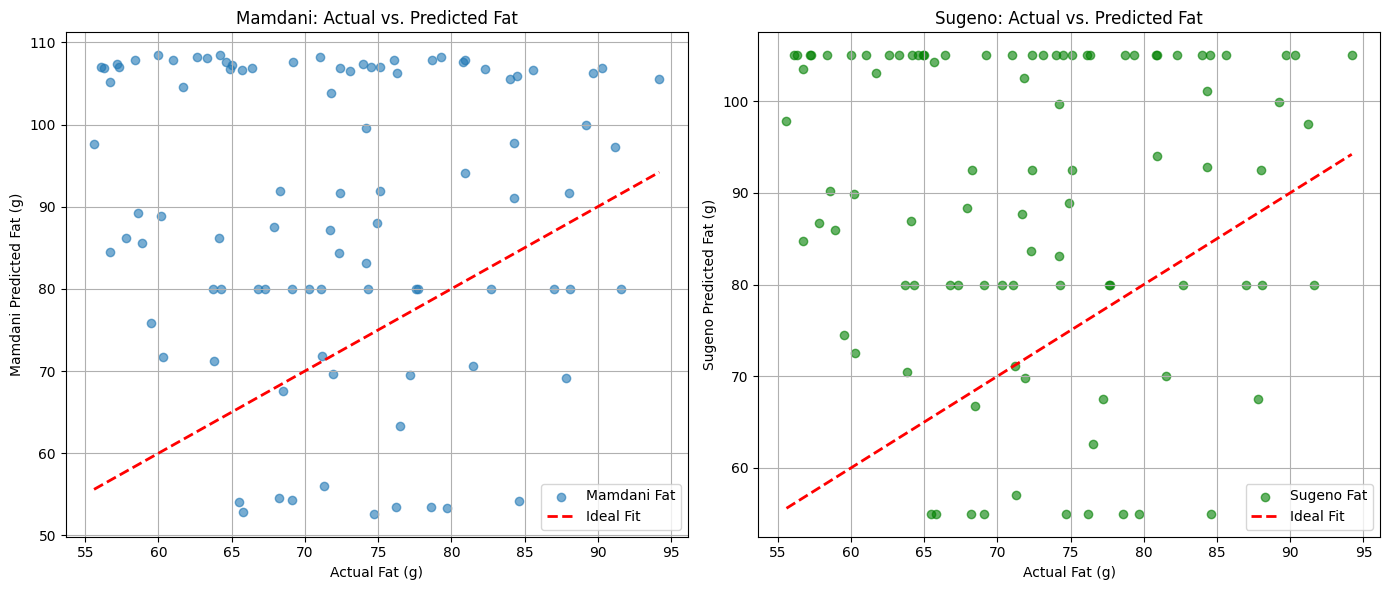

In [25]:
# Scatter plot of Actual vs. Predicted Fat
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(df_cleaned['Fat_g'], df_cleaned['Fat_Mamdani_Predicted'], alpha=0.6, label='Mamdani Fat')
plt.plot([df_cleaned['Fat_g'].min(), df_cleaned['Fat_g'].max()], 
         [df_cleaned['Fat_g'].min(), df_cleaned['Fat_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Fat (g)')
plt.ylabel('Mamdani Predicted Fat (g)')
plt.title('Mamdani: Actual vs. Predicted Fat')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(df_cleaned['Fat_g'], df_cleaned['Fat_Sugeno_Predicted'], alpha=0.6, color='green', label='Sugeno Fat')
plt.plot([df_cleaned['Fat_g'].min(), df_cleaned['Fat_g'].max()], 
         [df_cleaned['Fat_g'].min(), df_cleaned['Fat_g'].max()], 'r--', lw=2, label='Ideal Fit')
plt.xlabel('Actual Fat (g)')
plt.ylabel('Sugeno Predicted Fat (g)')
plt.title('Sugeno: Actual vs. Predicted Fat')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()